Ref:https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

Data:
    

In [2]:
vax = pd.read_csv('trainv.csv')

In [3]:
vax[:5]

,date,hospital,item,qty
0,01/01/21,1,1,13
1,02/01/21,1,1,11
2,03/01/21,1,1,14
3,04/01/21,1,1,13
4,05/01/21,1,1,10


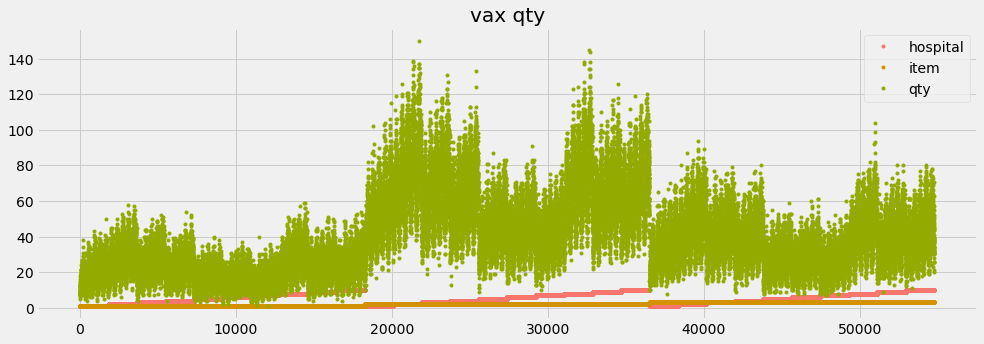

In [4]:
color_pal = ["#F8766D", "#D39200", "#93AA00"]
_ = vax.plot(style='.', figsize=(15,5), color=color_pal[:3], title='vax qty')

Splitting Vax data into Train/Test 

In [5]:
from sklearn.model_selection import train_test_split

# split into train test sets
vax_train, vax_test = train_test_split(vax,random_state=123, test_size=0.2)

#X_train , X_test ,y_train, y_test = train_test_split(vax.drop('qty',axis=1),vax.pop('qty'), random_state=123, test_size=0.2)

In [8]:
# DATES FEATURES
def create_features(df):
    # Date Features
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['dayofyear'] = df.date.dt.dayofyear
    df['dayofweek'] = df.date.dt.dayofweek
    df['weekofyear'] = df.date.dt.weekofyear
    
    # Additionnal Data Features
    #df['day^year'] = np.log((np.log(df['dayofyear'] + 1)) ** (df['year'] - 2000))
    
    # Drop date
    df.drop('date', axis=1, inplace=True)
    
    return df

# Dates Features for Train, Test
train, test = create_features(vax_train), create_features(vax_test)

<ipython-input-8-b2e5b79698b0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
<ipython-input-8-b2e5b79698b0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df.date.dt.year
<ipython-input-8-b2e5b79698b0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

 We will creat some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

In [10]:
train

,hospital,item,qty,year,month,day,dayofyear,dayofweek,weekofyear
21162,2,2,71,2021,3,13,72,5,10
13357,8,1,41,2021,6,30,181,2,26
30520,7,2,43,2021,6,28,179,0,26
29285,7,2,19,2021,11,3,307,2,44
3547,2,1,26,2021,6,18,169,4,24
...,...,...,...,...,...,...,...,...,...
54370,10,3,61,2021,4,17,107,5,15
17730,10,1,41,2021,6,20,171,6,24
28030,6,2,51,2021,3,5,64,4,9
15725,9,1,15,2021,1,23,23,5,3


In [14]:
train.shape,test.shape

((43824, 9), (10956, 9))

In [15]:
train[:5]

,hospital,item,qty,year,month,day,dayofyear,dayofweek,weekofyear
21162,2,2,71,2021,3,13,72,5,10
13357,8,1,41,2021,6,30,181,2,26
30520,7,2,43,2021,6,28,179,0,26
29285,7,2,19,2021,11,3,307,2,44
3547,2,1,26,2021,6,18,169,4,24


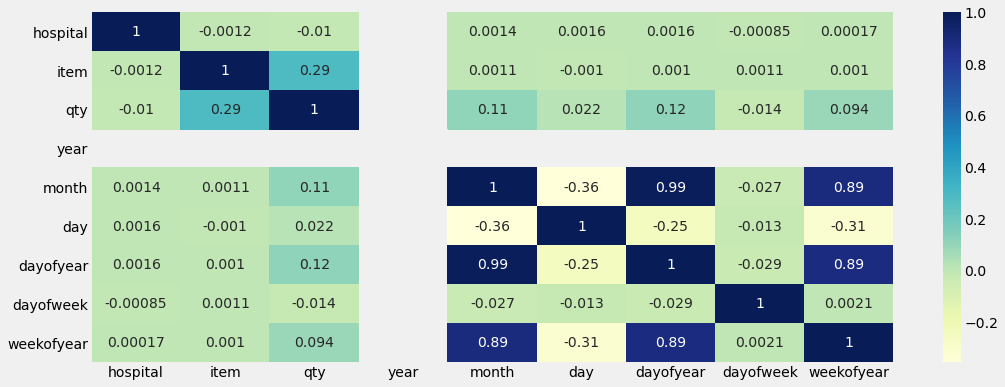

In [17]:
# plotting correlation heatmap
plt.figure(figsize=(16, 6))
dataplot = sns.heatmap(train.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

There so strong correlation with qty

In [42]:
# Training Data
X_train = train.drop('qty', axis=1).dropna()
y_train = train['qty']

#Testing Data
X_test = test.drop('qty', axis=1).dropna()
y_test = test['qty']
#y_test.shape

(10956,)

Creating XGBoost Model

In [24]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the hospital was most commonly used to split trees, while item and day came in next. Weekofyear has low importance due to the fact that it could be created by same year splits. 

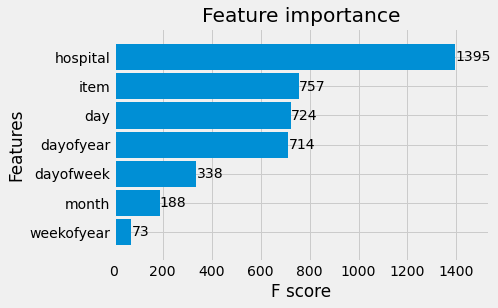

In [23]:
_ = plot_importance(reg, height=0.9)

Forecast on Test Set

In [37]:
vax_test['VD_Prediction'] = reg.predict(X_test)
vax_all = pd.concat([vax_test, vax_train], sort=False)

<ipython-input-37-692e5f75ca81>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vax_test['VD_Prediction'] = reg.predict(X_test)


In [39]:
vax_test['VD_Prediction']

51103    35.613525
53604    42.990330
12676    17.486143
22072    78.074364
36433    69.556358
           ...    
27935    50.953419
14688    19.357782
19043    41.360508
37129    39.781384
3907     29.059277
Name: VD_Prediction, Length: 10956, dtype: float32

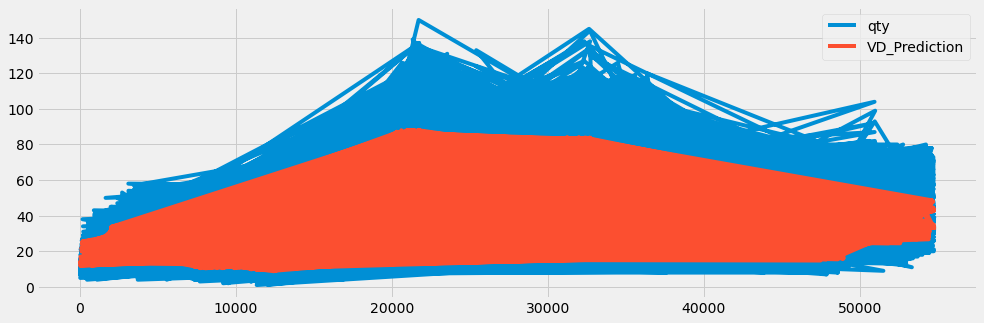

In [44]:
_ = vax_all[['qty','VD_Prediction']].plot(figsize=(15, 5))